El cuaderno ha sido ejecutado sobre una maquina virtual de  ubuntu arm en un MacBook Pro M1. Se hace uso de parallels, asignando 4 cores y 6 GB de RAM.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import findspark
findspark.init()
import random
from pyspark import SparkContext
import pyspark
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
sc = SparkContext("local[*]", "Name of the Program")

25/03/01 17:52:36 WARN Utils: Your hostname, ubuntu-linux-22-04-desktop resolves to a loopback address: 127.0.1.1; using 10.211.55.3 instead (on interface enp0s5)
25/03/01 17:52:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/01 17:52:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:

def readFile(filename):
    rdd = sc.textFile(filename)
    rdd_numpy = rdd.map(lambda x : np.array(x.split(","), dtype = float))
    rdd_return = rdd_numpy.map(lambda x : (x[:-1], int(x[-1])))
    return rdd_return

def normalize_value(x, mean, std):
    value = (x[0] - mean) / std
    normalized_val = np.nan_to_num(value, copy=False, nan=0.0)
    return (normalized_val, x[1])

def normalize(RDD_Xy):
    
    rdd_sum = RDD_Xy.reduce(lambda x, y: (np.array(x[0]) + np.array(y[0]), x[1]))
    total_rows = float(RDD_Xy.count())
    mean = rdd_sum[0] / total_rows

    rdd_mean = RDD_Xy.map(lambda x: (x[0], x[1], mean)) 

    rdd_substract = rdd_mean.map(lambda x: (x[0] - x[2]) ** 2)
    rdd_total = rdd_substract.reduce(lambda x, y: x + y)
    std = (rdd_total / total_rows) ** 0.5
 

    rdd_normalized = RDD_Xy.map(lambda x: normalize_value(x, mean, std))
    return rdd_normalized

def predict(w, b, X, threshold=0.5):
    value = np.dot(w, X) + b
    value = 1 / (1 + np.exp(-value))
    return  1 if value > threshold else 0

def loss_function(x):
    return (-x[1] * np.log(x[0]) - (1 - x[1]) * np.log(1 - x[0]))

def calculate_loss_function(predictions_and_targets,lambda_reg,w):   
    """
    Calculate the loss function for logistic regression
    :param predictions_and_targets: RDD with the predictions and the targets
    :param lambda_reg: regularization parameter
    :param w: weights
    :return: loss function
    """

    loss = predictions_and_targets.map(loss_function)
    sum = loss.reduce(lambda x,y: x + y) / predictions_and_targets.count()
    squared_w = np.dot(w, w)
    squared_w = squared_w * lambda_reg / (2 * len(w))
    return sum + squared_w

def predict_train(w, b, X,):
    value = np.dot(w, X) + b
    return 1 / (1 + np.exp(-value))

def train(RDD_Xy, iterations, learning_rate, lambda_reg):
    w = np.random.rand(11)
    b = np.random.rand(1)
    
    for iteration in range(iterations):
        predictions_targets_inputs = RDD_Xy.map(lambda x: (predict_train(w, b, x[0]), x[1], x[0]))
        
        count = predictions_targets_inputs.count()
        
        gradients = predictions_targets_inputs.map(lambda x: ((x[0] - x[1]) * np.array(x[2]), x[0] - x[1]))
        
        gradient_w = gradients.map(lambda x: x[0]).reduce(lambda x, y: x + y) / count + (lambda_reg * w) / len(w)
        gradient_b = gradients.map(lambda x: x[1]).reduce(lambda x, y: x + y) / count
        
        w -= learning_rate * gradient_w
        b -= learning_rate * gradient_b
        
        loss = calculate_loss_function(predictions_targets_inputs, lambda_reg, w)
        print(f"Iteration: {iteration}, Loss: {loss}")
    
    return w, b

def accuracy(w,b,RDD_Xy):
    predictions_and_targets = RDD_Xy.map(lambda x: (predict(w, b, x[0]), x[1]))
    correct = predictions_and_targets.map(lambda x: 1 if round(x[0]) == x[1] else 0)
    correct = correct.reduce(lambda x, y: x + y)
    return correct / predictions_and_targets.count()

def transform(data,num_blocks_cv):
    data = data.map(lambda x: (random.randint(0, num_blocks_cv-1), x[0], x[1]))
    return data

def get_block_data(data_cv: pyspark.rdd.RDD, i):
    train_data = data_cv.flatMap(lambda x: [(x[1], x[2])] if x[0] != i else [])
    test_data = data_cv.flatMap(lambda x: [(x[1], x[2])] if x[0] == i else [])
    return train_data, test_data


## **EJERCICIO 1**

In [4]:
n = readFile('/home/parallels/Desktop/spark/OGVD-project-MAADM-UPM/data/botnet_reduced_10k_l.csv')

normalizado = normalize(n)

w,b=train(normalizado,10,1.5,0)

acc=accuracy(w,b,normalizado)
print(f"Final accuracy: {acc}")

Iteration: 0, Loss: [0.65376924]
Iteration: 1, Loss: [0.43447902]
Iteration: 2, Loss: [0.3419656]
Iteration: 3, Loss: [0.29560722]
Iteration: 4, Loss: [0.26857065]
Iteration: 5, Loss: [0.25093636]
Iteration: 6, Loss: [0.2385026]
Iteration: 7, Loss: [0.22923849]
Iteration: 8, Loss: [0.22205094]
Iteration: 9, Loss: [0.2163003]
Final accuracy: 0.9269


## **EJERCICIO 2**

In [5]:
num_blocks_cv=10
rdd_with_keys = transform(normalizado, num_blocks_cv)
rdd_with_keys.cache()
_ = rdd_with_keys.count() # to cache the data
all_ac=[]
for i in range(num_blocks_cv):
    train_data, test_data = get_block_data(rdd_with_keys, i)
    print("-"*50)
    print(f"Block {i}")
    w,b=train(train_data,10,1.5,0)
    acc=accuracy(w,b,test_data)
    all_ac.append(acc)
    print(f"Accuracy: {acc}")
print(f"Mean accuracy: {np.mean(all_ac)}")

--------------------------------------------------
Block 0
Iteration: 0, Loss: [0.6565269]
Iteration: 1, Loss: [0.43508397]
Iteration: 2, Loss: [0.33961292]
Iteration: 3, Loss: [0.29194578]
Iteration: 4, Loss: [0.26468901]
Iteration: 5, Loss: [0.24732534]
Iteration: 6, Loss: [0.23535106]
Iteration: 7, Loss: [0.22659418]
Iteration: 8, Loss: [0.2198986]
Iteration: 9, Loss: [0.21459916]
Accuracy: 0.9375
--------------------------------------------------
Block 1
Iteration: 0, Loss: [0.76845175]
Iteration: 1, Loss: [0.46452209]
Iteration: 2, Loss: [0.34960214]
Iteration: 3, Loss: [0.29737155]
Iteration: 4, Loss: [0.26854306]
Iteration: 5, Loss: [0.25034422]
Iteration: 6, Loss: [0.23778417]
Iteration: 7, Loss: [0.22856584]
Iteration: 8, Loss: [0.2214929]
Iteration: 9, Loss: [0.21588195]
Accuracy: 0.9430569430569431
--------------------------------------------------
Block 2
Iteration: 0, Loss: [0.76736775]
Iteration: 1, Loss: [0.46994701]
Iteration: 2, Loss: [0.3596287]
Iteration: 3, Loss: [0

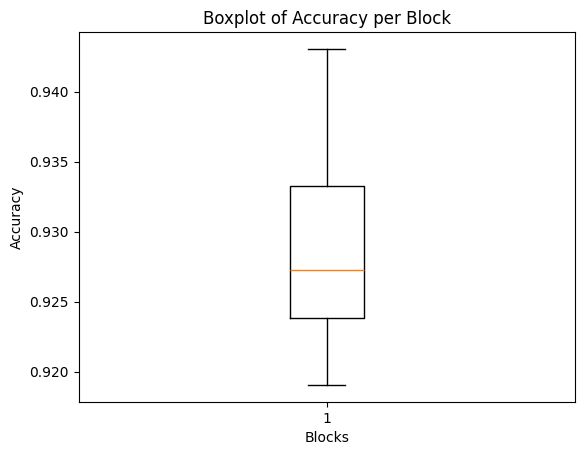

In [6]:
import matplotlib.pyplot as plt
plt.boxplot(all_ac)
plt.xlabel('Blocks')
plt.ylabel('Accuracy')
plt.title('Boxplot of Accuracy per Block')
plt.show()

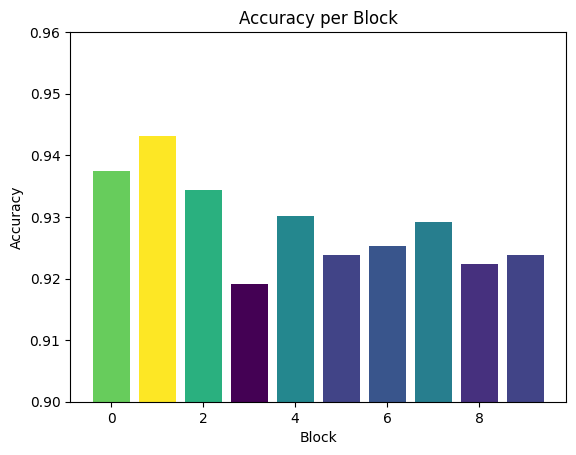

In [7]:
colors = plt.cm.viridis((np.array(all_ac) - min(all_ac)) / (max(all_ac) - min(all_ac)))
plt.bar(range(num_blocks_cv), all_ac, color=colors)
plt.xlabel('Block')
plt.ylabel('Accuracy')
plt.title('Accuracy per Block')
plt.ylim(0.90, 0.96)
plt.show()


# Memoria parte 1

In [8]:
def ej1_train(RDD_Xy, iterations, learning_rate, lambda_reg):
    w = np.random.rand(11)
    b = np.random.rand(1)
    costs = []
    for iteration in range(iterations):
        predictions_targets_inputs = RDD_Xy.map(lambda x: (predict_train(w, b, x[0]), x[1], x[0]))
        
        count = predictions_targets_inputs.count()
        
        gradients = predictions_targets_inputs.map(lambda x: ((x[0] - x[1]) * np.array(x[2]), x[0] - x[1]))
        
        gradient_w = gradients.map(lambda x: x[0]).reduce(lambda x, y: x + y) / count + (lambda_reg * w) / len(w)
        gradient_b = gradients.map(lambda x: x[1]).reduce(lambda x, y: x + y) / count
        
        w -= learning_rate * gradient_w
        b -= learning_rate * gradient_b
        
        loss = calculate_loss_function(predictions_targets_inputs, lambda_reg, w)
        costs.append(loss)
    return w, b, costs

Learning rates: 100%|██████████| 7/7 [00:58<00:00,  8.33s/it]


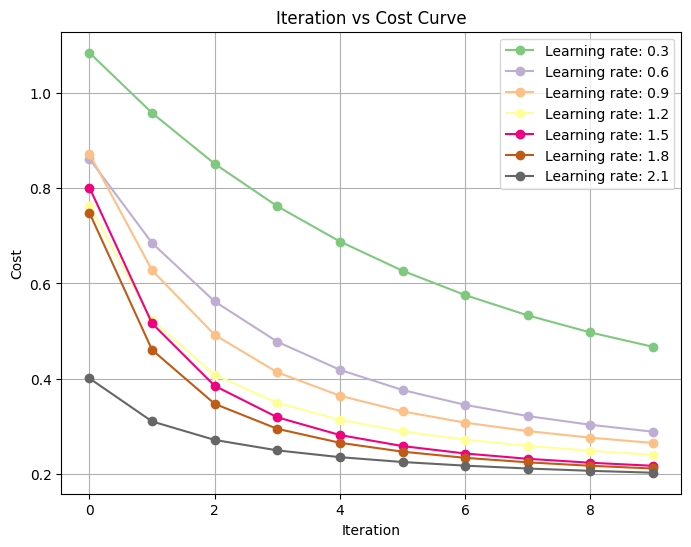

In [9]:
n = readFile('/home/parallels/Desktop/spark/OGVD-project-MAADM-UPM/data/botnet_reduced_10k_l.csv')

normalizado = normalize(n)
total_costs=[]
learning_rates=[0.3,0.6,0.9,1.2,1.5,1.8,2.1]

colors = plt.cm.Accent((np.array(learning_rates) - min(learning_rates)) / (max(learning_rates) - min(learning_rates)))
lambda_reg=0
plt.figure(figsize=(8, 6))
for learning_rate in tqdm(learning_rates, desc=f"Learning rates"):
    w,b,costs=ej1_train(normalizado,10,learning_rate,0)
    total_costs.append(costs)

    plt.plot(costs, marker='o', linestyle='-',color=colors[learning_rates.index(learning_rate)],label=f"Learning rate: {learning_rate}")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Iteration vs Cost Curve")
plt.grid()
plt.legend()
plt.savefig(f"results/Ej_1_cost_curve_learning_rate_10k.png")  # Guardar imagen
plt.show()

Lambdas:   0%|          | 0/7 [00:00<?, ?it/s]

0


Lambdas:  14%|█▍        | 1/7 [00:08<00:50,  8.37s/it]

0.1


Lambdas:  29%|██▊       | 2/7 [00:16<00:41,  8.38s/it]

0.2


Lambdas:  43%|████▎     | 3/7 [00:25<00:33,  8.39s/it]

0.3


Lambdas:  57%|█████▋    | 4/7 [00:34<00:25,  8.60s/it]

0.4


Lambdas:  71%|███████▏  | 5/7 [00:42<00:17,  8.54s/it]

0.5


Lambdas:  86%|████████▌ | 6/7 [00:50<00:08,  8.46s/it]

0.6


Lambdas: 100%|██████████| 7/7 [00:59<00:00,  8.45s/it]


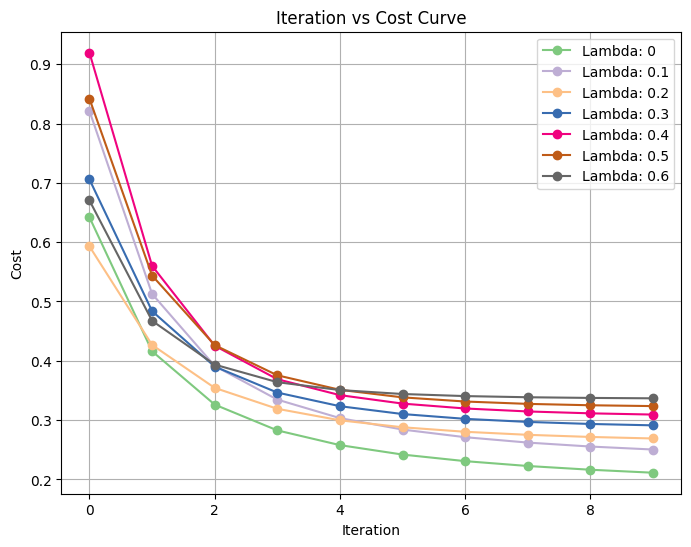

In [10]:
n = readFile('/home/parallels/Desktop/spark/OGVD-project-MAADM-UPM/data/botnet_reduced_10k_l.csv')

normalizado = normalize(n)
lambdas=[0,0.1,0.2,0.3,0.4,0.5,0.6]

colors = plt.cm.Accent((np.array(lambdas) - min(lambdas)) / (max(lambdas) - min(lambdas)))
plt.figure(figsize=(8, 6))
for lamb in tqdm(lambdas, desc=f"Lambdas"):
    print(lamb)
    w,b,costs=ej1_train(normalizado,10,1.5,lamb)

    plt.plot(costs, marker='o', linestyle='-',color=colors[lambdas.index(lamb)],label=f"Lambda: {lamb}")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Iteration vs Cost Curve")
plt.grid()
plt.legend()
plt.savefig(f"results/Ej_1_cost_curve_lambda_10k.png")  # Guardar imagen
plt.show()

## Memoria Parte 2

Workers:   0%|          | 0/7 [00:00<?, ?it/s]

1


Workers:  14%|█▍        | 1/7 [00:14<01:25, 14.27s/it]

2


Workers:  29%|██▊       | 2/7 [00:24<00:58, 11.65s/it]

3


Workers:  43%|████▎     | 3/7 [00:33<00:43, 10.78s/it]

4


Workers:  57%|█████▋    | 4/7 [00:43<00:31, 10.37s/it]

5


Workers:  71%|███████▏  | 5/7 [00:53<00:20, 10.17s/it]

6


Workers:  86%|████████▌ | 6/7 [01:03<00:10, 10.01s/it]

7


Workers: 100%|██████████| 7/7 [01:12<00:00, 10.39s/it]


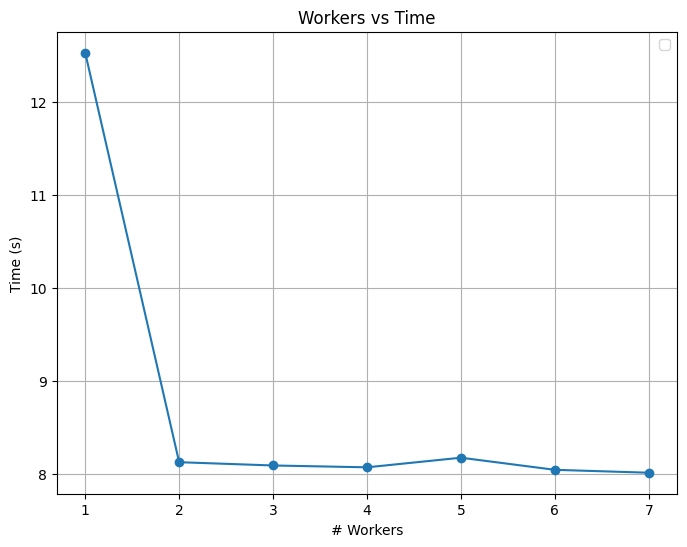

In [11]:

n_worker=4
workers=range(1,n_worker+4)

try:
    sc.stop()
except:
    pass
totals=[]
plt.figure(figsize=(8, 6))
for worker in tqdm(workers, desc=f"Workers"):
    print(worker)
    sc = SparkContext(f"local[{worker}]", "Name of the Program")
    n = readFile('/home/parallels/Desktop/spark/OGVD-project-MAADM-UPM/data/botnet_reduced_10k_l.csv')   
    normalizado = normalize(n)
    inicio=time.time()
    w,b,costs=ej1_train(normalizado,10,1.5,0)
    fin=time.time()
    sc.stop()
    totals.append(fin-inicio)

plt.plot(range(1, len(totals) + 1), totals, marker='o', linestyle='-')
plt.xlabel("# Workers")
plt.ylabel("Time (s)")
plt.title("Workers vs Time")
plt.grid()
plt.legend()
plt.savefig(f"results/Ej_2_time_workers_10k.png") 
plt.show()

Ratios de aceleración: {2: 1.5408057104150539, 3: 1.5475184043124526, 4: 1.551295542377628, 5: 1.531722763890937, 6: 1.5564894574469301, 7: 1.5625300114874672}


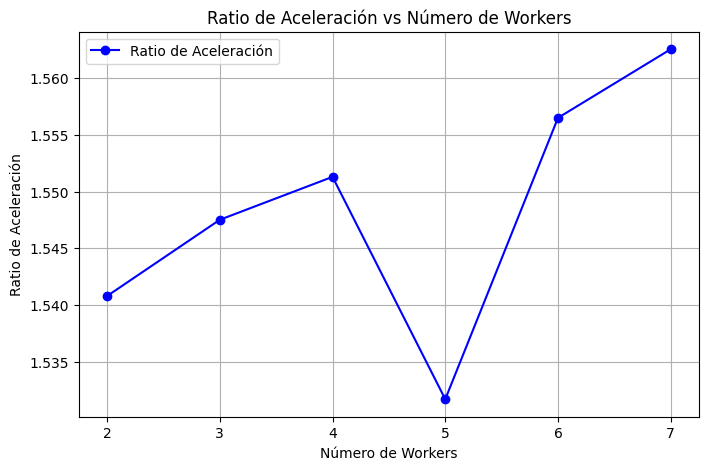

In [12]:
# Tiempos calculados de la ejecucion anterior
def calcular_ratio_aceleracion(tiempo_worker_1, tiempos_workers_n):
    """
    Calcula el ratio de aceleración del tiempo.
    
    :param tiempo_worker_1: Tiempo de ejecución con 1 worker.
    :param tiempos_workers_n: Diccionario con claves como número de workers y valores como tiempos de ejecución.
    :return: Diccionario con claves como número de workers y valores como ratio de aceleración.
    """
    ratio_aceleracion = {}
    for n, tiempo_n in tiempos_workers_n.items():
        if tiempo_n > 0:
            ratio_aceleracion[n] = tiempo_worker_1 / tiempo_n
        else:
            ratio_aceleracion[n] = None  
    
    return ratio_aceleracion

# Ejemplo de uso
tiempo_worker_1 = totals[0]  # Tiempo de ejecución con 1 worker en segundos
tiempos_workers_n = {
    2: totals[1],
    3: totals[2],
    4: totals[3],
    5: totals[4],
    6: totals[5],
    7: totals[6]
}

ratios = calcular_ratio_aceleracion(tiempo_worker_1, tiempos_workers_n)
print("Ratios de aceleración:", ratios)

# Graficar los resultados
plt.figure(figsize=(8, 5))
plt.plot(list(ratios.keys()), list(ratios.values()), marker='o', linestyle='-', color='b', label='Ratio de Aceleración')
plt.xlabel("Número de Workers")
plt.ylabel("Ratio de Aceleración")
plt.title("Ratio de Aceleración vs Número de Workers")
plt.legend()
plt.grid()
plt.savefig(f"results/Ej_2_speed_up_10k.png") 

plt.show()


## Memoria Parte 3

### Tiempo normal

In [15]:
sc = SparkContext("local[*]", "Name of the Program")

In [ ]:

n = readFile('/home/parallels/Desktop/spark/OGVD-project-MAADM-UPM/data/botnet_reduced_10k_l.csv')
start_time = time.time()
normalizado = normalize(n)

w,b=train(normalizado,10,1.5,0)

acc=accuracy(w,b,normalizado)
print(f"Final accuracy: {acc}")
end_time = time.time()
normal_time = end_time - start_time
print(normal_time)

Iteration: 0, Loss: [0.64601756]


### Cacheamos el normalizado

In [ ]:

n = readFile('/home/parallels/Desktop/spark/OGVD-project-MAADM-UPM/data/botnet_reduced_10k_l.csv')
start_time = time.time()
normalizado = normalize(n)
normalizado.cache()
_ = normalizado.count()
w,b=train(normalizado,10,1.5,0)

acc=accuracy(w,b,normalizado)
print(f"Final accuracy: {acc}")
end_time = time.time()
cached_normalizado = end_time - start_time
print(cached_normalizado)

Iteration: 0, Loss: [0.69745567]


Iteration: 1, Loss: [0.4178144]


Iteration: 2, Loss: [0.33056604]


Iteration: 3, Loss: [0.29057757]


Iteration: 4, Loss: [0.26670944]


Iteration: 5, Loss: [0.25041489]


Iteration: 6, Loss: [0.23841285]


Iteration: 7, Loss: [0.22913761]


Iteration: 8, Loss: [0.22172752]


Iteration: 9, Loss: [0.21565999]


Final accuracy: 0.927782
138.7232768535614


### Cachemos gradientes

In [ ]:
def train_cached_grad(RDD_Xy, iterations, learning_rate, lambda_reg):
    w = np.random.rand(11)
    b = np.random.rand(1)
    
    for iteration in range(iterations):
        predictions_targets_inputs = RDD_Xy.map(lambda x: (predict_train(w, b, x[0]), x[1], x[0]))
        
        count = predictions_targets_inputs.count()
        
        gradients = predictions_targets_inputs.map(lambda x: ((x[0] - x[1]) * np.array(x[2]), x[0] - x[1]))
        gradients.cache()
        _ = gradients.count()
        gradient_w = gradients.map(lambda x: x[0]).reduce(lambda x, y: x + y) / count + (lambda_reg * w) / len(w)
        gradient_b = gradients.map(lambda x: x[1]).reduce(lambda x, y: x + y) / count
        
        w -= learning_rate * gradient_w
        b -= learning_rate * gradient_b
        
        loss = calculate_loss_function(predictions_targets_inputs, lambda_reg, w)
        print(f"Iteration: {iteration}, Loss: {loss}")
    
    return w, b

In [ ]:

n = readFile('/home/parallels/Desktop/spark/OGVD-project-MAADM-UPM/data/botnet_reduced_10k_l.csv')
start_time = time.time()
normalizado = normalize(n)
# normalizado.cache()
# _ = normalizado.count()
w,b=train_cached_grad(normalizado,10,1.5,0)

acc=accuracy(w,b,normalizado)
print(f"Final accuracy: {acc}")
end_time = time.time()
cached_gradients = end_time - start_time
print(cached_gradients)

Iteration: 0, Loss: [0.60371984]


Iteration: 1, Loss: [0.41089351]


Iteration: 2, Loss: [0.32906885]


Iteration: 3, Loss: [0.28693942]


Iteration: 4, Loss: [0.2616604]


Iteration: 5, Loss: [0.24482078]


Iteration: 6, Loss: [0.23277175]


Iteration: 7, Loss: [0.22370025]


Iteration: 8, Loss: [0.2166074]


Iteration: 9, Loss: [0.21089804]


Final accuracy: 0.929422
326.60360765457153


### Cachemos gradients y normalizado

In [ ]:

n = readFile('/home/parallels/Desktop/spark/OGVD-project-MAADM-UPM/data/botnet_reduced_10k_l.csv')
start_time = time.time()
normalizado = normalize(n)
normalizado.cache()
_ = normalizado.count()
w,b=train_cached_grad(normalizado,10,1.5,0)

acc=accuracy(w,b,normalizado)
print(f"Final accuracy: {acc}")
end_time = time.time()
cached_gradients_normalizado = end_time - start_time
print(cached_gradients_normalizado)

Iteration: 0, Loss: [0.52522284]


Iteration: 1, Loss: [0.37084194]


Iteration: 2, Loss: [0.3059474]


Iteration: 3, Loss: [0.27198092]


Iteration: 4, Loss: [0.25125138]


Iteration: 5, Loss: [0.23722173]


Iteration: 6, Loss: [0.22703297]


Iteration: 7, Loss: [0.21925441]


Iteration: 8, Loss: [0.21309305]


Iteration: 9, Loss: [0.20807364]


Final accuracy: 0.930166
168.1287760734558


### Cacheamos el predict en el train

In [ ]:
def train_cached_pred(RDD_Xy, iterations, learning_rate, lambda_reg):
    w = np.random.rand(11)
    b = np.random.rand(1)
    
    for iteration in range(iterations):
        predictions_targets_inputs = RDD_Xy.map(lambda x: (predict_train(w, b, x[0]), x[1], x[0]))
        predictions_targets_inputs.cache()
        count = predictions_targets_inputs.count()
        
        gradients = predictions_targets_inputs.map(lambda x: ((x[0] - x[1]) * np.array(x[2]), x[0] - x[1]))
        # gradients.cache()
        # _ = gradients.count()
        gradient_w = gradients.map(lambda x: x[0]).reduce(lambda x, y: x + y) / count + (lambda_reg * w) / len(w)
        gradient_b = gradients.map(lambda x: x[1]).reduce(lambda x, y: x + y) / count
        
        w -= learning_rate * gradient_w
        b -= learning_rate * gradient_b
        
        loss = calculate_loss_function(predictions_targets_inputs, lambda_reg, w)
        print(f"Iteration: {iteration}, Loss: {loss}")
    
    return w, b

In [ ]:

n = readFile('/home/parallels/Desktop/spark/OGVD-project-MAADM-UPM/data/botnet_reduced_10k_l.csv')
start_time = time.time()
# normalizado = normalize(n)
# normalizado.cache()
_ = normalizado.count()
w,b=train_cached_pred(normalizado,10,1.5,0)

acc=accuracy(w,b,normalizado)
print(f"Final accuracy: {acc}")
end_time = time.time()
cached_predict = end_time - start_time
print(cached_predict)

Iteration: 0, Loss: [1.56045633]


Iteration: 1, Loss: [0.879741]


Iteration: 2, Loss: [0.57067817]


Iteration: 3, Loss: [0.42073854]


Iteration: 4, Loss: [0.34155126]


Iteration: 5, Loss: [0.29651429]


Iteration: 6, Loss: [0.26865552]


Iteration: 7, Loss: [0.25004285]


Iteration: 8, Loss: [0.23680976]


Iteration: 9, Loss: [0.22693319]


Final accuracy: 0.924384
133.5286865234375


### Chacheamos predict y grads

In [ ]:
def train_cached(RDD_Xy, iterations, learning_rate, lambda_reg):
    w = np.random.rand(11)
    b = np.random.rand(1)
    
    for iteration in range(iterations):
        predictions_targets_inputs = RDD_Xy.map(lambda x: (predict_train(w, b, x[0]), x[1], x[0]))
        predictions_targets_inputs.cache()
        count = predictions_targets_inputs.count()
        
        gradients = predictions_targets_inputs.map(lambda x: ((x[0] - x[1]) * np.array(x[2]), x[0] - x[1]))
        gradients.cache()
        _ = gradients.count()
        gradient_w = gradients.map(lambda x: x[0]).reduce(lambda x, y: x + y) / count + (lambda_reg * w) / len(w)
        gradient_b = gradients.map(lambda x: x[1]).reduce(lambda x, y: x + y) / count
        
        w -= learning_rate * gradient_w
        b -= learning_rate * gradient_b
        
        loss = calculate_loss_function(predictions_targets_inputs, lambda_reg, w)
        print(f"Iteration: {iteration}, Loss: {loss}")
    
    return w, b

In [ ]:

n = readFile('/home/parallels/Desktop/spark/OGVD-project-MAADM-UPM/data/botnet_reduced_10k_l.csv')
start_time = time.time()
# normalizado = normalize(n)
# normalizado.cache()
_ = normalizado.count()
w,b=train_cached(normalizado,10,1.5,0)

acc=accuracy(w,b,normalizado)
print(f"Final accuracy: {acc}")
end_time = time.time()
cached_predict_grad = end_time - start_time
print(cached_predict_grad)

Iteration: 0, Loss: [1.26240287]


Iteration: 1, Loss: [0.65870928]


Iteration: 2, Loss: [0.42941584]


Iteration: 3, Loss: [0.33445842]


Iteration: 4, Loss: [0.28784551]


Iteration: 5, Loss: [0.26104966]


Iteration: 6, Loss: [0.24373674]


Iteration: 7, Loss: [0.23160209]


Iteration: 8, Loss: [0.22259112]


Iteration: 9, Loss: [0.21560947]


Final accuracy: 0.928932
159.42531728744507


### Cacheamos predict y normalizado

In [ ]:

n = readFile('/home/parallels/Desktop/spark/OGVD-project-MAADM-UPM/data/botnet_reduced_10k_l.csv')
start_time = time.time()
normalizado = normalize(n)
normalizado.cache()
_ = normalizado.count()
w,b=train_cached_pred(normalizado,10,1.5,0)

acc=accuracy(w,b,normalizado)
print(f"Final accuracy: {acc}")
end_time = time.time()
cached_predict_norm = end_time - start_time
print(cached_predict_norm)

Iteration: 0, Loss: [1.32535647]


Iteration: 1, Loss: [0.63905099]


Iteration: 2, Loss: [0.40392771]


Iteration: 3, Loss: [0.32432161]


Iteration: 4, Loss: [0.28680604]


Iteration: 5, Loss: [0.26409271]


Iteration: 6, Loss: [0.24848618]


Iteration: 7, Loss: [0.23695571]


Iteration: 8, Loss: [0.22802624]


Iteration: 9, Loss: [0.22087726]


Final accuracy: 0.929148
143.0418345928192


### Combinamos los tres

In [ ]:

n = readFile('/home/parallels/Desktop/spark/OGVD-project-MAADM-UPM/data/botnet_reduced_10k_l.csv')
start_time = time.time()
normalizado = normalize(n)
normalizado.cache()
_ = normalizado.count()
w,b=train_cached_pred(normalizado,10,1.5,0)

acc=accuracy(w,b,normalizado)
print(f"Final accuracy: {acc}")
end_time = time.time()
cached_all = end_time - start_time
print(cached_all)

Iteration: 0, Loss: [1.05443327]


Iteration: 1, Loss: [0.50993538]


Iteration: 2, Loss: [0.36056097]


Iteration: 3, Loss: [0.30368172]


Iteration: 4, Loss: [0.27337205]


Iteration: 5, Loss: [0.25417918]


Iteration: 6, Loss: [0.24075037]


Iteration: 7, Loss: [0.23073143]


Iteration: 8, Loss: [0.22291652]


Iteration: 9, Loss: [0.21661954]


Final accuracy: 0.930109
139.8809049129486


### Plot

[336.11903166770935, 138.7232768535614, 326.60360765457153, 168.1287760734558, 133.5286865234375, 159.42531728744507, 143.0418345928192, 139.8809049129486]


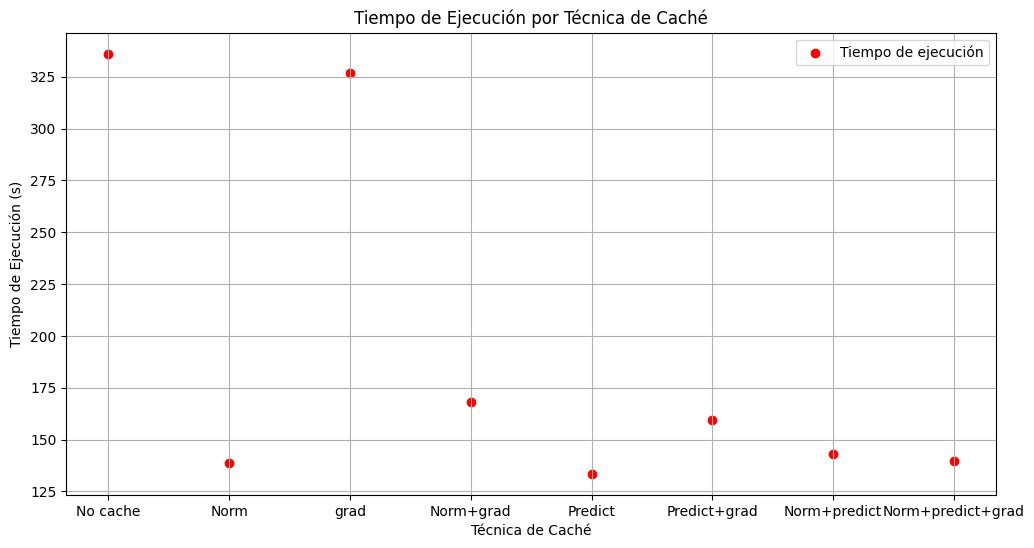

In [ ]:
tecnicas_cache = ["No cache", "Norm", "grad", "Norm+grad", "Predict", 'Predict+grad', 'Norm+predict','Norm+predict+grad']
tiempos_cache = [normal_time, cached_normalizado, cached_gradients, cached_gradients_normalizado, cached_predict, cached_predict_grad, cached_predict_norm, cached_all]  # Ejemplo de tiempos en segundos
print(tiempos_cache)
plt.figure(figsize=(12, 6))
plt.scatter(tecnicas_cache, tiempos_cache, color='r', label='Tiempo de ejecución')
plt.xlabel("Técnica de Caché")
plt.ylabel("Tiempo de Ejecución (s)")
plt.title("Tiempo de Ejecución por Técnica de Caché")
plt.legend()
plt.grid()
plt.savefig(f"results/Ej_3a_cached_10k.png") 

plt.show()


## Memoria Parte 4

Partitions:   0%|          | 0/8 [00:00<?, ?it/s]

1


Partitions:  12%|█▎        | 1/8 [07:11<50:19, 431.33s/it]                      

2


Partitions:  25%|██▌       | 2/8 [10:53<30:50, 308.48s/it]                      

3


Partitions:  38%|███▊      | 3/8 [13:42<20:24, 244.82s/it]                      

4


Partitions:  50%|█████     | 4/8 [16:07<13:41, 205.45s/it]                      

5


Partitions:  62%|██████▎   | 5/8 [19:23<10:06, 202.01s/it]                      

6


Partitions:  75%|███████▌  | 6/8 [22:16<06:24, 192.00s/it]                      

7


Partitions:  88%|████████▊ | 7/8 [24:48<02:58, 178.97s/it]                      

8


Partitions: 100%|██████████| 8/8 [27:12<00:00, 204.08s/it]                      


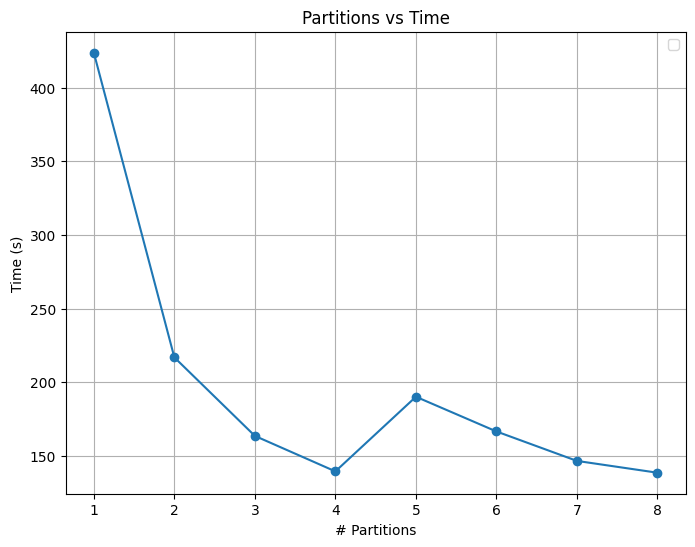

In [ ]:
partitions=range(1,9)


try:
    sc.stop()
except:
    pass
sc = SparkContext(f"local[{4}]", "Name of the Program")
totals=[]
plt.figure(figsize=(8, 6))
for partition in tqdm(partitions, desc=f"Partitions"):
    print(partition)
    n = readFile('/home/parallels/Desktop/spark/OGVD-project-MAADM-UPM/data/botnet_reduced_10k_l.csv')   
    normalizado = normalize(n)
    normalizado=normalizado.repartition(partition)

    inicio=time.time()
    w,b,costs=ej1_train(normalizado,10,1.5,0)
    fin=time.time()
    totals.append(fin-inicio)

plt.plot(range(1, len(totals) + 1), totals, marker='o', linestyle='-')
plt.xlabel("# Partitions")
plt.ylabel("Time (s)")
plt.title("Partitions vs Time")
plt.grid()
plt.legend()
plt.savefig(f"results/Ej_4_time_partitions_10k.png") 
plt.show()